In [7]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 生成数据集

In [8]:
max_degree = 20  #多项式的最大阶数
n_train, n_test = 100, 100 #训练和测试集大小
true_w = np.zeros(max_degree) #分配空间
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) #设置初始w

features = np.random.normal(size=(n_train + n_test,1))
np.random.shuffle(features)
#x的多少次方
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features,true_w)
#scale是标准差
labels += np.random.normal(scale=0.1, size=labels.shape)

In [9]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]


(tensor([[-0.3866],
         [ 1.0936]]),
 tensor([[ 1.0000e+00, -3.8658e-01,  7.4720e-02, -9.6283e-03,  9.3052e-04,
          -7.1943e-05,  4.6352e-06, -2.5598e-07,  1.2369e-08, -5.3130e-10,
           2.0539e-11, -7.2180e-13,  2.3252e-14, -6.9145e-16,  1.9093e-17,
          -4.9205e-19,  1.1888e-20, -2.7034e-22,  5.8059e-24, -1.1813e-25],
         [ 1.0000e+00,  1.0936e+00,  5.9795e-01,  2.1797e-01,  5.9591e-02,
           1.3034e-02,  2.3755e-03,  3.7112e-04,  5.0731e-05,  6.1642e-06,
           6.7410e-07,  6.7016e-08,  6.1073e-09,  5.1375e-10,  4.0131e-11,
           2.9257e-12,  1.9997e-13,  1.2864e-14,  7.8152e-16,  4.4981e-17]]),
 tensor([4.2437, 5.5928]))

## 训练和测试

In [10]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [14]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    #最后一个维度的size
    input_shape = test_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    # print('weight:', net[0].weight.data.numpy())


## 三阶多项式函数拟合(正常)
我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。

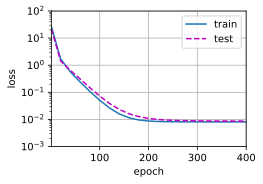

In [15]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])


## 线性函数拟合(欠拟合)
让我们再看看线性函数拟合，减少该模型的训练损失相对困难。 在最后一个迭代周期完成后，训练损失仍然很高。 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合

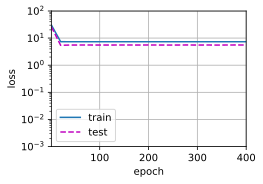

In [16]:
#从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 高阶多项式函数拟合(过拟合)

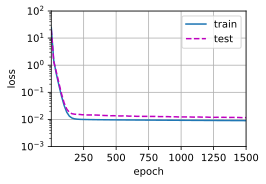

In [17]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)